This notebook is for the second model, which only takes in one zoom level as input (magnification 2). We can compare this with our other combined model to see which performs better. 

In [2]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
import shutil
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray
import tensorflow as tf 
from tensorflow import keras
import pandas as pd

In [3]:
!pip install pyyaml h5py 

## Preprocessing

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
slides_folder = '/content/drive/My Drive/slides'

slides = os.listdir(slides_folder)

In [6]:
# create training set with this data first 

#retrieve mask and slide pairs 
slide_paths = [] 
mask_paths = [] 

for slide in slides: 
  #assign mask and slide respectively 
  if "tif" in slide:
    if "mask" in slide: 
      mask_paths.append(slide)
    else:
      slide_paths.append(slide)

#check that each slide has a mask 
for slide in slide_paths: 
  assoc_mask_path = slide[:-4] + "_mask.tif"
  if assoc_mask_path not in mask_paths: 
    print(slide)

In [7]:
# from the code above it seems that slide tumor_038 does not have a mask so we have to discard it 

#slide_paths.remove("tumor_038.tif")
print(len(slide_paths))
print(len(mask_paths))

#match up the slide and mask paths 
slide_paths.sort() 
mask_paths.sort()

print(slide_paths[15])
print(mask_paths[15])

21
21
tumor_084.tif
tumor_084_mask.tif


In [8]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [9]:
# now get data from a low zoom level to create a starter training set 

# use sliding window to get patches from low zoom level 5, find corresponding labels, discard gray areas

# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

In [10]:
# initialize pos/neg patches and masks folder 

pos_directory = "/content/drive/My Drive/slides/pos_patches_model2/"
neg_directory = "/content/drive/My Drive/slides/neg_patches_model2/"

In [10]:
#get each patch, determine whether to discard or not, then find label

def split_pos_neg_patches(patch_size, level, slide, mask, pos_directory, neg_directory): 

  num_patches = [slide.level_dimensions[level][0]//patch_size, slide.level_dimensions[level][1]//patch_size]
  ds_factor = 2**level 

  #since we are using a low zoom level, cannot read every single patch, so we are reading every other patch 
  for i in range(0, num_patches[0]):
    for j in range(0, num_patches[1]):

      #get the patch first 
      patch = read_slide(slide, i*patch_size*ds_factor, j*patch_size*ds_factor, level, patch_size, patch_size)

      #find tissue areas
      tissue_pixels = find_tissue_pixels(patch)
      percent_tissue = (len(tissue_pixels) / (patch_size * patch_size)) * 100

      #based on tissue percentage( > 25) decide if keep or discard 
      if percent_tissue > 25: 

        #decide label now by using mask patch 
        mask_patch = read_slide(mask, i*patch_size*ds_factor, j*patch_size*ds_factor, level, patch_size, patch_size)

        #find center patch of mask 
        mask_center = [((i*patch_size) + (patch_size//2)) * ds_factor, ((j*patch_size) + (patch_size//2)) * ds_factor]
        mask_patch = mask_patch[:,:,0]

        file = slide_paths[0][:-4] + '_patch_'+ str(i) + '_' + str(j) + '_level_' + str(level) + ".npy"
        
        #if any region of the mask has a 1, can classify as cancerous 
        if np.sum(mask_patch) >= 1:  
          #save np array to image file 
          
          with open(pos_directory + file, 'wb') as f:
            np.save(f, patch)

        else: 
          #classify as negative label 

          with open(neg_directory + file, 'wb') as h:
            np.save(h, patch)

  return None 

In [31]:
#train on 5 full slides for zoom level 2

for i in range(13, 18): 
  slide_path = slides_folder + "/" + slide_paths[i]
  mask_path = slides_folder + "/" + mask_paths[i]

  slide = open_slide(slide_path)
  mask = open_slide(mask_path) 

  split_pos_neg_patches(299, 2, slide, mask, pos_directory, neg_directory)
  print("done for one slide")

done for one slide
done for one slide
done for one slide
done for one slide
done for one slide


In [50]:
pos_level2 = [] 
neg_level2 = []


for name in os.listdir(pos_directory):
  pos_img = np.load(pos_directory + name)
  pos_level2.append(pos_img)

for name in os.listdir(neg_directory):
  neg_img = np.load(neg_directory + name)
  neg_level2.append(neg_img)

In [51]:
#this is a highly unbalanced dataset, our next step is to balance it 

print("Total Positive:", len(pos_level2))
print("Total Negative:", len(neg_level2))

Total Positive: 355
Total Negative: 4251


In [52]:
#balancing the dataset for training

training_arrays = np.concatenate([np.stack(neg_level2[:355], axis=0), np.stack(pos_level2, axis=0)], axis=0)

testing_y = [0 for i in range(355)] + [1 for i in range(355)]
testing_y = np.asarray(testing_y)

print(training_arrays.shape)
print(testing_y.shape)

(710, 299, 299, 3)
(710,)


In [53]:
#split the dataset into train and validation (80/20 split)

l2_X_train, l2_X_val, y_train, y_val = train_test_split(training_arrays, testing_y, test_size=0.2, random_state=42)

print(l2_X_train.shape, l2_X_val.shape, y_train.shape, y_val.shape)


(568, 299, 299, 3) (142, 299, 299, 3) (568,) (142,)


## Model Creation

In [54]:
#this method generates the model for the single input model 

def gen_model(patch_size):

  base_model_1 = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3),
                                                include_top=False,
                                                weights='imagenet') 
  
  base_model_1.trainable = False
  global_average_layer_1 = tf.keras.layers.GlobalAveragePooling2D()
  input_1 = tf.keras.layers.Input(shape=(patch_size, patch_size, 3)) 

  model_1 = tf.keras.Sequential([
    base_model_1,
    global_average_layer_1
  ])

  model_1 = model_1(input_1)
  prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')(model_1)
  model = tf.keras.models.Model(inputs=input_1, outputs=prediction_layer)

  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  
  return model 

In [55]:
model = gen_model(299)

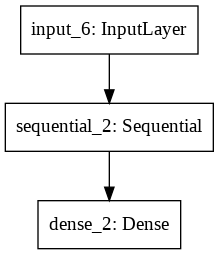

In [56]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [57]:
history = model.fit(l2_X_train, y_train, epochs=25, validation_data=(l2_X_val, y_val)) 

Epoch 1/25
18/18 [==============================] - 106s 6s/step - loss: 4.1840 - accuracy: 0.4802 - val_loss: 2.2556 - val_accuracy: 0.5986
Epoch 2/25
18/18 [==============================] - 100s 6s/step - loss: 1.6937 - accuracy: 0.6583 - val_loss: 1.3121 - val_accuracy: 0.6901
Epoch 3/25
18/18 [==============================] - 100s 6s/step - loss: 1.0544 - accuracy: 0.7041 - val_loss: 1.2012 - val_accuracy: 0.6831
Epoch 4/25
18/18 [==============================] - 100s 6s/step - loss: 0.8973 - accuracy: 0.7107 - val_loss: 0.9634 - val_accuracy: 0.7324
Epoch 5/25
18/18 [==============================] - 100s 6s/step - loss: 0.7432 - accuracy: 0.7647 - val_loss: 0.9874 - val_accuracy: 0.7324
Epoch 6/25
18/18 [==============================] - 100s 6s/step - loss: 0.7485 - accuracy: 0.7402 - val_loss: 0.8776 - val_accuracy: 0.7324
Epoch 7/25
18/18 [==============================] - 100s 6s/step - loss: 0.6697 - accuracy: 0.7830 - val_loss: 1.1814 - val_accuracy: 0.7113
Epoch 8/25
18

Highest Training Accuracy: 86.06% <br> 
Highest Validation Accuracy: 80.28% 

In [62]:
#save model as checkpoint here 

model.save('my_model_2.h5')

## Testing Analysis

In [11]:
#load the model

model = keras.models.load_model("my_model_2.h5")

In [12]:
#creating heatmaps on test slides 

def generate_heatmap(slide, mask, patch_size, model, level):

  #get the number of patches in the slide 
  num_patches = [slide.level_dimensions[level][0]//patch_size, slide.level_dimensions[level][1]//patch_size]
  ds_factor = 2**level 

  y_test = [] #true values
  preds = []  #predicted values 
  whole_mask = [] 
  whole_slide = [] 

  for i in range(num_patches[0]):
    col_mask_patches = []
    slide_patches = [] 
    for j in range(num_patches[1]):
      #read the patch and then append to slide_patches (idea is to concatenate them into a row of patches)
      patch = read_slide(slide, i*patch_size*ds_factor, j*patch_size*ds_factor, level, patch_size, patch_size)
      slide_patches.append(patch)

      tissue_pixels = find_tissue_pixels(patch)
      percent_tissue = (len(tissue_pixels) / (patch_size * patch_size)) * 100

      mask_patch = read_slide(mask, i*patch_size*ds_factor, j*patch_size*ds_factor, level, patch_size, patch_size)
      mask_patch = mask_patch[:, :, 0]

      #need copy because actual mask is read only 
      mask_copy = np.zeros(mask_patch.shape)

      #only predict on patch if tissue percentage > 25
      if percent_tissue > 25: 
        mask_patch = read_slide(mask, i*patch_size*ds_factor, j*patch_size*ds_factor, level, patch_size, patch_size)

        #reshape to fit into model 
        patch = np.expand_dims(patch, axis=0)

        #get the prediction
        pred_1 = model.predict(patch)

        #final prediction is a probability for each class so have to round 
        final_pred = np.round(pred_1[0][0])
        preds.append(final_pred)

        #get actual answer from mask and add to y_test 
        if np.sum(mask_patch) >= 1: 
          y_test.append(1.0)
        else: 
          y_test.append(0.0)

        #color the mask in if it is predicted to be cancerous 
        if final_pred == 1.0: 
          mask_copy[0:patch_size, 0:patch_size] = 1

      col_mask_patches.append(mask_copy)

    #combine the row mask patches and slide patches 
    col_mask_patches = np.concatenate(col_mask_patches, axis=0)
    slide_patches = np.concatenate(slide_patches, axis = 0)
    whole_mask.append(col_mask_patches) 
    whole_slide.append(slide_patches)

  #combine all the column patches to create the whole mask and whole slide 
  whole_mask = np.concatenate(whole_mask, axis=1)
  whole_slide = np.concatenate(whole_slide, axis=1)
  return whole_slide, whole_mask, y_test, preds  


In [17]:
def get_preds(slide, mask, patch_size, model, level):

  #get the number of patches in the slide 
  num_patches = [slide.level_dimensions[level][0]//patch_size, slide.level_dimensions[level][1]//patch_size]
  ds_factor = 2**level 

  y_test = [] #true values
  preds = []  #predicted values 

  for i in range(num_patches[0]): 
    for j in range(num_patches[1]):
      #read the patch and then append to slide_patches (idea is to concatenate them into a row of patches)
      patch = read_slide(slide, i*patch_size*ds_factor, j*patch_size*ds_factor, level, patch_size, patch_size)

      tissue_pixels = find_tissue_pixels(patch)
      percent_tissue = (len(tissue_pixels) / (patch_size * patch_size)) * 100

      mask_patch = read_slide(mask, i*patch_size*ds_factor, j*patch_size*ds_factor, level, patch_size, patch_size)
      mask_patch = mask_patch[:, :, 0]

      #only predict on patch if tissue percentage > 25
      if percent_tissue > 25: 
        mask_patch = read_slide(mask, i*patch_size*ds_factor, j*patch_size*ds_factor, level, patch_size, patch_size)

        #reshape to fit into model 
        patch = np.expand_dims(patch, axis=0)

        #get the prediction
        pred_1 = model.predict(patch)

        #final prediction is a probability for each class so have to round 
        final_pred = np.round(pred_1[0][0])
        preds.append(final_pred)

        #get actual answer from mask and add to y_test 
        if np.sum(mask_patch) >= 1: 
          y_test.append(1.0)
        else: 
          y_test.append(0.0)

  return y_test, preds  

In [13]:
#return the accuracy given the predicted and true values 
def accuracy(y_test, preds):
  count = 0 
  for i in range(len(y_test)):
    count += int(y_test[i] == preds[i])

  return count/len(y_test)

#return the precision, recall, and confusion matrix given the predicted and true values 
def precision_and_recall(y_test, preds):
  test_df_ratings = pd.DataFrame()
  test_df_ratings['prediction'] = preds
  test_df_ratings['actual'] = y_test

  #find count of true positive, true negative, etc...
  tp = 0
  fp = 0 
  fn = 0 
  tn = 0 
  for i in range(len(test_df_ratings)):
    if (test_df_ratings['actual'][i] == 1) &(test_df_ratings['prediction'][i] == 1):
      tp += 1
    elif (test_df_ratings['actual'][i] == 1) &(test_df_ratings['prediction'][i] == 0):
      fn += 1
    elif (test_df_ratings['actual'][i] == 0) &(test_df_ratings['prediction'][i] == 1):
      fp += 1
    elif (test_df_ratings['actual'][i] == 0) &(test_df_ratings['prediction'][i] == 0):
      tn += 1

  if sum(test_df_ratings['prediction']) == 0: 
    precision = None
  else: 
    precision = tp / sum(test_df_ratings['prediction'])

  recall = tp / sum(test_df_ratings['actual'])

  #build confusion matrix 
  cf_matrix = pd.DataFrame() 
  cf_matrix['Actual_0'] = [tn, fp]
  cf_matrix['Actual_1'] = [fn, tp]

  return precision, recall, cf_matrix

#### First Test Slide Metrics/Analysis

In [21]:
#open the first test slide and test mask 
test_slide_1 = open_slide(slides_folder + "/" + slide_paths[7])
test_mask_1 = open_slide(slides_folder + "/" + mask_paths[7])

**Generated HeatMap from Model**

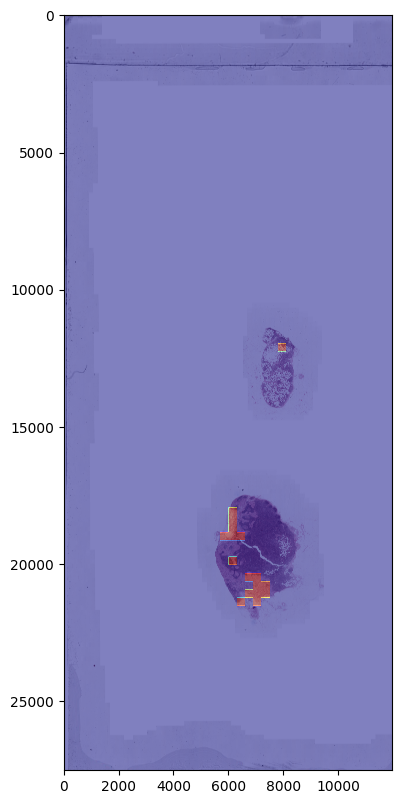

In [15]:
slide_map, mask_heatmap, y_test_ts1, preds_ts1 = generate_heatmap(test_slide_1, test_mask_1, 299, model, 3)

#plot the heatmap 
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_map)
plt.imshow(mask_heatmap, cmap='jet', alpha=0.5) # Red regions contains cancer.

**True Mask on Test Slide**

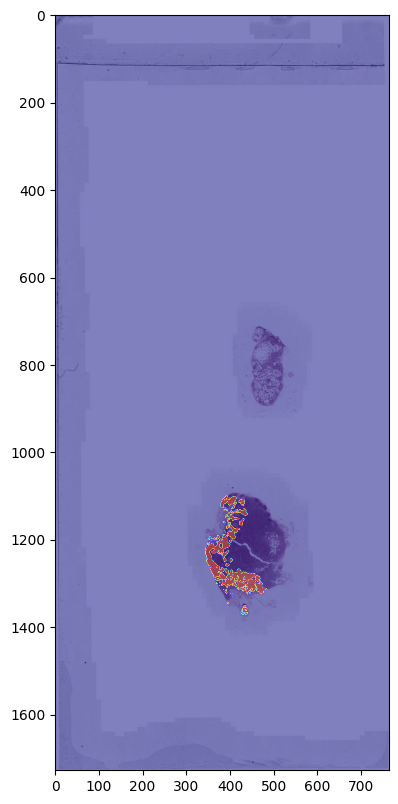

In [36]:
slide_image = read_slide(test_slide_1, 
                         x=0, 
                         y=0, 
                         level=7, 
                         width=test_slide_1.level_dimensions[7][0], 
                         height=test_slide_1.level_dimensions[7][1])


mask_image = read_slide(test_mask_1, 
                        x=0, 
                        y=0, 
                        level=7, 
                        width=test_slide_1.level_dimensions[7][0], 
                        height=test_slide_1.level_dimensions[7][1])

mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

*Accuracy Metrics on First Test Slide*

In [22]:
y_test_ts1, preds_ts1 = get_preds(test_slide_1, test_mask_1, 299, model, 2)

In [23]:
accuracy_ts_1 = accuracy(y_test_ts1, preds_ts1)
precision_ts_1, recall_ts_1, cf_matrix_ts_1 = precision_and_recall(y_test_ts1, preds_ts1)
print("Accuracy:", accuracy_ts_1)
print() 
print("Precision:", precision_ts_1)
print("Recall:", recall_ts_1)

cf_matrix_ts_1

Accuracy: 0.7322033898305085

Precision: 0.5673469387755102
Recall: 0.7277486910994765


,Actual_0,Actual_1
0,293,52
1,106,139


## Second Test Slide Metrics/Analysis

**Generated HeatMap**

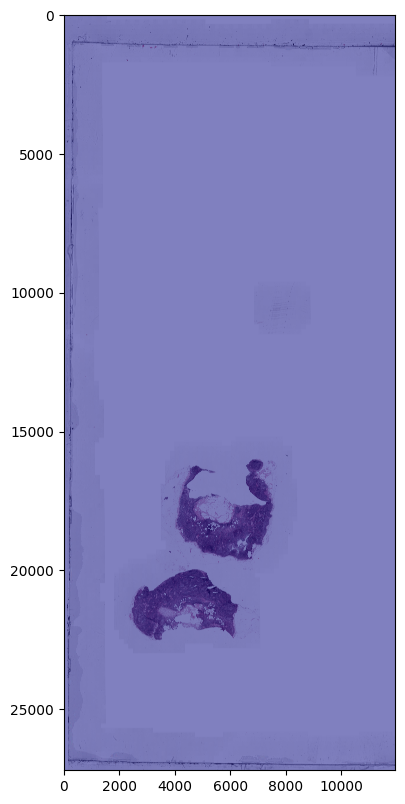

In [14]:
test_slide_2 = open_slide(slides_folder + "/" + slide_paths[2])
test_mask_2 = open_slide(slides_folder + "/" + mask_paths[2])

slide_map, mask_heatmap, y_test_ts2, preds_ts2 = generate_heatmap(test_slide_2, test_mask_2, 299, model, 3)

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_map)
plt.imshow(mask_heatmap, cmap='jet', alpha=0.5) # Red regions contains cancer.

**True Mask on Slide**

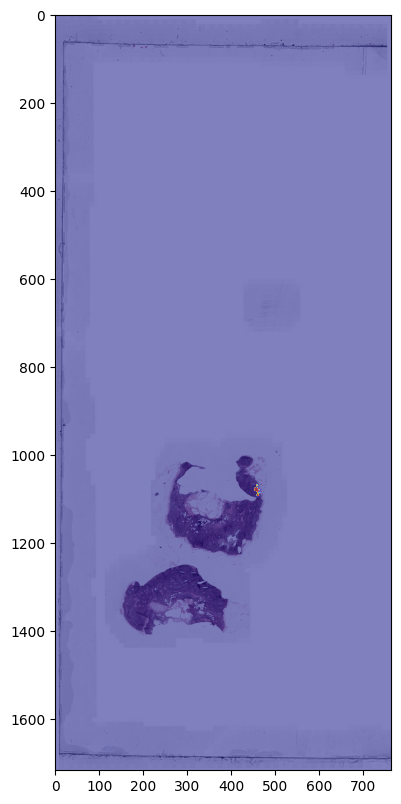

In [15]:
slide_image = read_slide(test_slide_2, 
                         x=0, 
                         y=0, 
                         level=7, 
                         width=test_slide_2.level_dimensions[7][0], 
                         height=test_slide_2.level_dimensions[7][1])


mask_image = read_slide(test_mask_2, 
                        x=0, 
                        y=0, 
                        level=7, 
                        width=test_slide_2.level_dimensions[7][0], 
                        height=test_slide_2.level_dimensions[7][1])

mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

*Accuracy Metrics on Second Test Slide*

In [20]:
#this can be thrown out there were no true positives 

accuracy_ts_2 = accuracy(y_test_ts2, preds_ts2)
precision_ts_2, recall_ts_2, cf_matrix_ts_2 = precision_and_recall(y_test_ts2, preds_ts2)
print("Accuracy:", accuracy_ts_2)
print() 
print("Precision:", precision_ts_2)
print("Recall:", recall_ts_2)

cf_matrix_ts_2

Accuracy: 0.9880239520958084

Precision: None
Recall: 0.0


,Actual_0,Actual_1
0,165,2
1,0,0


## Third Test Slide Metrics/Analysis

**Generated HeatMap from Model**

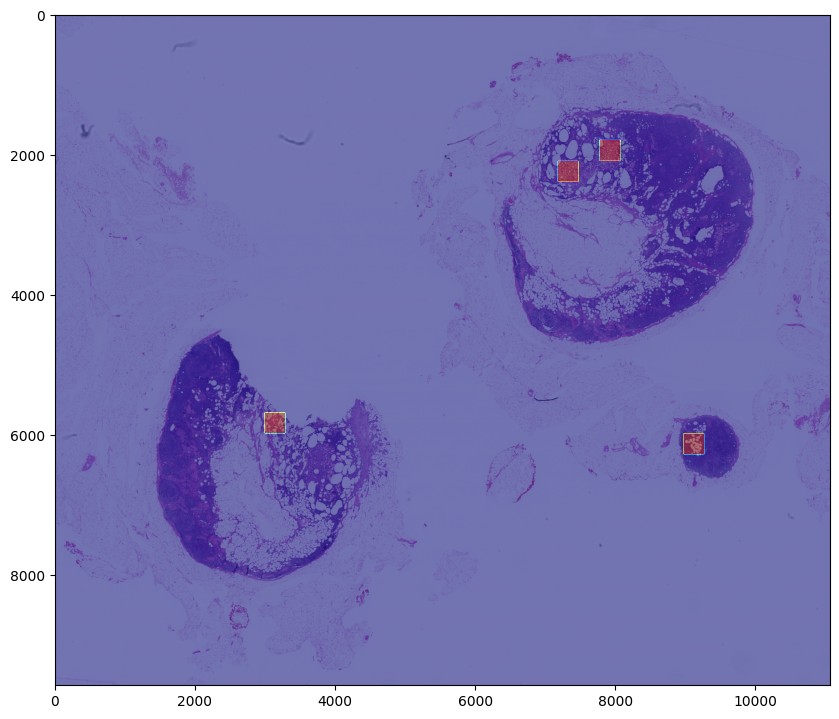

In [28]:
test_slide_3 = open_slide(slides_folder + "/" + slide_paths[12])
test_mask_3 = open_slide(slides_folder + "/" + mask_paths[12])

slide_map, mask_heatmap, y_test_ts3, preds_ts3 = generate_heatmap(test_slide_3, test_mask_3, 299, model, 3)

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_map)
plt.imshow(mask_heatmap, cmap='jet', alpha=0.5) # Red regions contains cancer.

**True Mask on Test Slide**

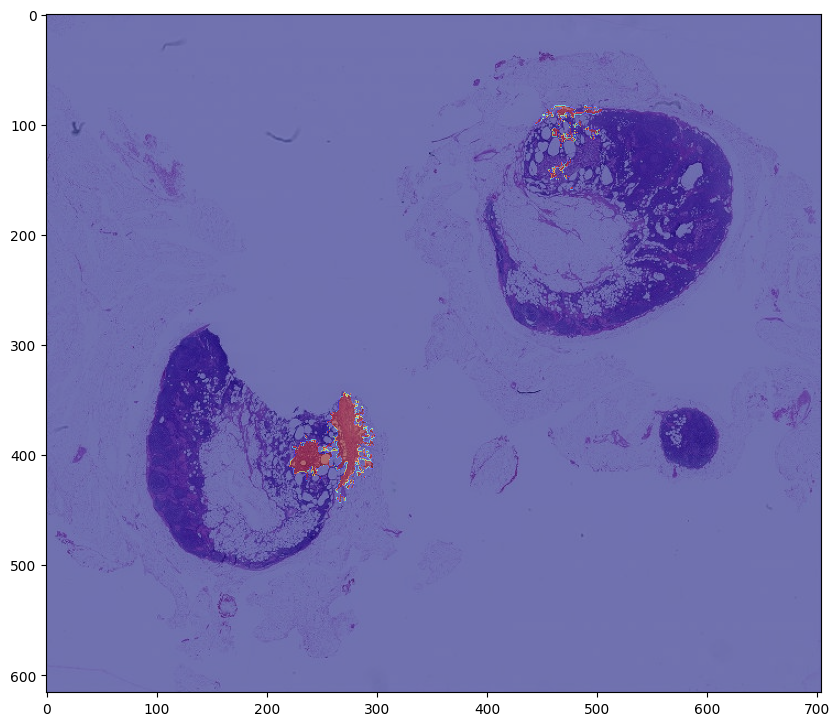

In [27]:
slide_image = read_slide(test_slide_3, 
                         x=0, 
                         y=0, 
                         level=7, 
                         width=test_slide_3.level_dimensions[7][0], 
                         height=test_slide_3.level_dimensions[7][1])


mask_image = read_slide(test_mask_3, 
                        x=0, 
                        y=0, 
                        level=7, 
                        width=test_slide_3.level_dimensions[7][0], 
                        height=test_slide_3.level_dimensions[7][1])

mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

*Accuracy Metrics on Test Slide*

In [29]:
y_test_ts3, preds_ts3 = get_preds(test_slide_3, test_mask_3, 299, model, 2)

In [30]:
accuracy_ts_3 = accuracy(y_test_ts3, preds_ts3)
precision_ts_3, recall_ts_3, cf_matrix_ts_3 = precision_and_recall(y_test_ts3, preds_ts3)
print("Accuracy:", accuracy_ts_3)
print() 
print("Precision:", precision_ts_3)
print("Recall:", recall_ts_3)

cf_matrix_ts_3

Accuracy: 0.8060522696011004

Precision: 0.175
Recall: 0.15730337078651685


,Actual_0,Actual_1
0,572,75
1,66,14
